# Ca channels: recovery from inactivation

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ca channel recordings in the "data/Ca_channels" folder

In [2]:
data_folder = "data/3-Ca_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/3-Ca_channels


['data/3-Ca_channels/2025_06_09_0008.abf',
 'data/3-Ca_channels/2025_06_09_0009.abf',
 'data/3-Ca_channels/2025_06_09_0002.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/3-Ca_channels/2025_06_09_0009.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_09_0009.abf')
Number of sweeps: 26
Points per sweep: 60,000
Duration per sweep: 6.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


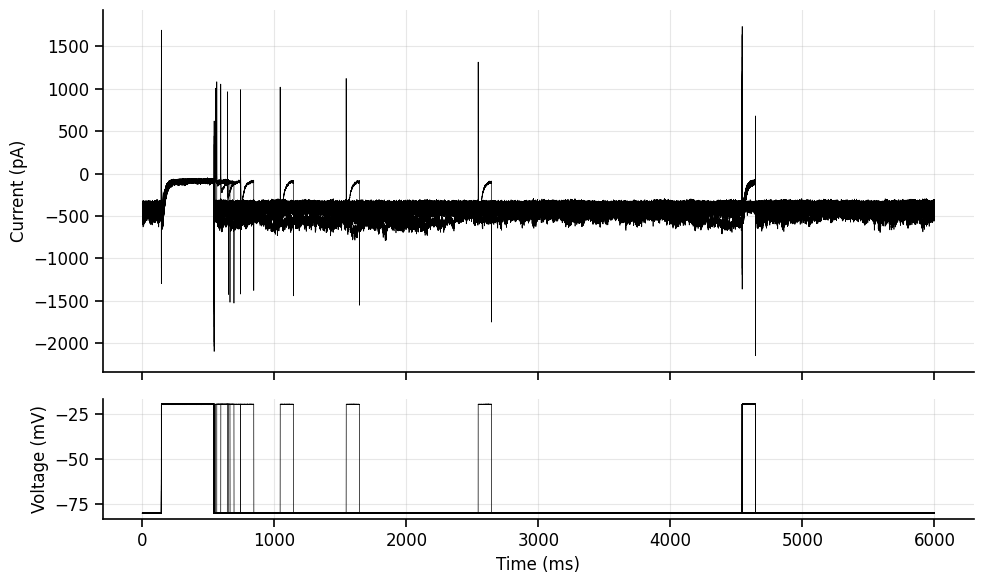

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------
# The %matplotlib widget lines makes plots interactive (but sometimes is a bit buggy, doesn't always work)

# %matplotlib widget
%matplotlib inline
traces.plot(plot_voltage=True, 
            time_units=time_units, 
            sweep='all')  # Options: 'all', or enter a number here if you want to plot individual sweeps
plt.show()
v_step_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+5, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-403.0749 -396.6048 -439.7942 ... -387.6436 -414.6997 -393.2602]


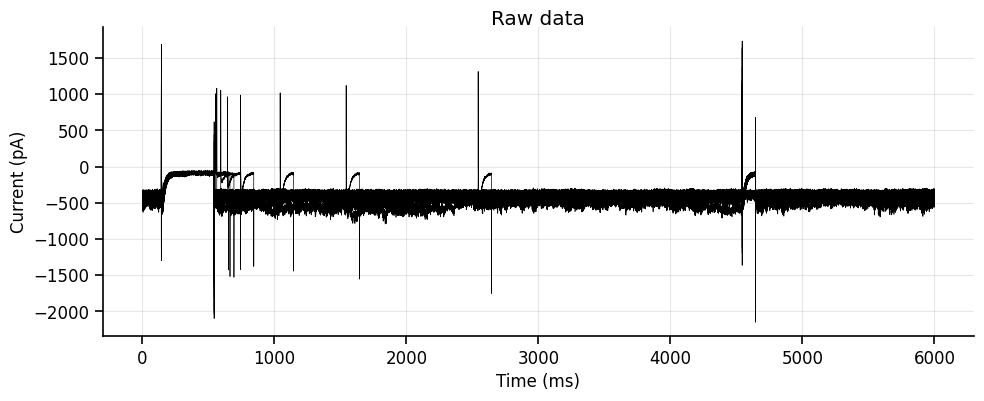

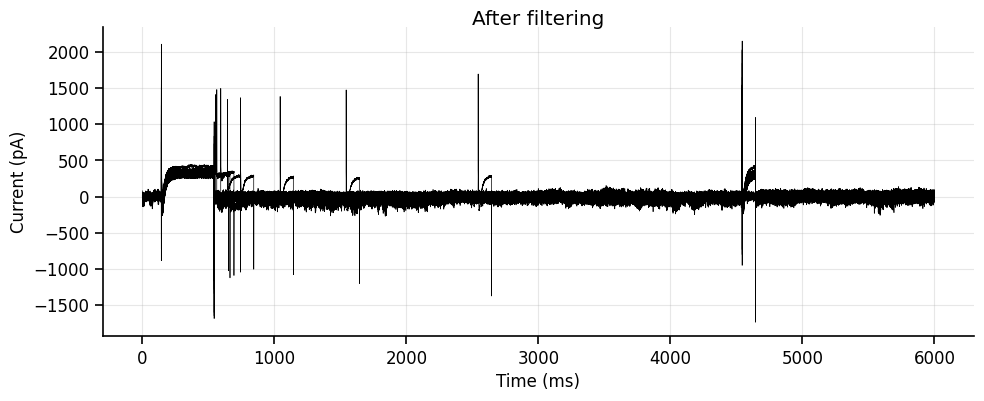

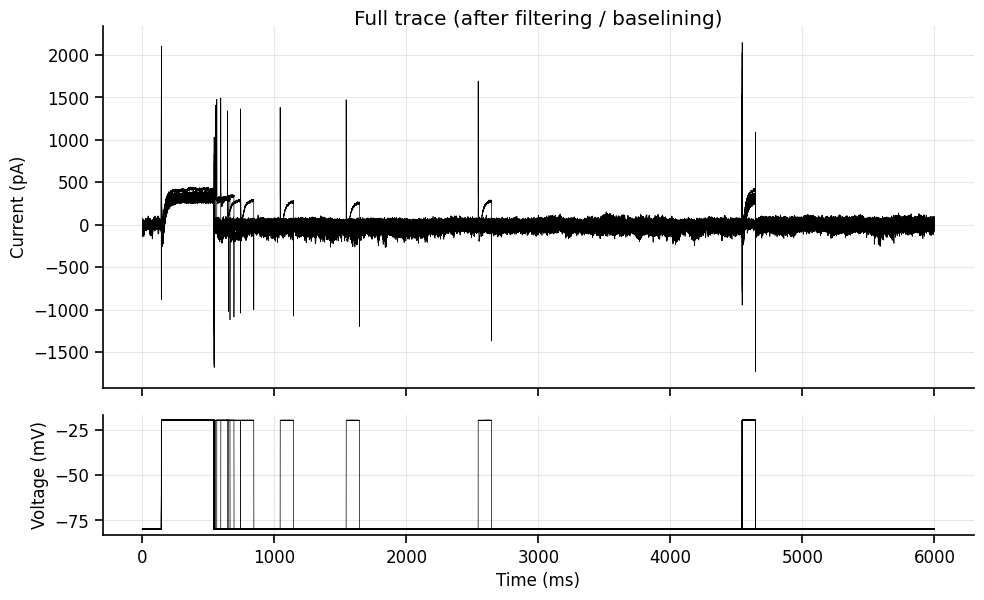

In [5]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = 0  # Start time for baseline subtraction
    end_baseline = v_step_start[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=True, time_units=time_units, sweep='all')
    ax[0].set_title('Full trace (after filtering / baselining)', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [6]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure recovery currents

#### 3.1 Reference current

First let's get the times of all the voltage steps

In [7]:
step_times = traces.get_step_events(threshold=traces.voltage_data[0,0]+5, polarity='positive', sweep='all',
                                   edge='rising', channel='voltage', time_units=time_units)
print(f"Step times:")
step_times

Step times:


[array([143.7, 553.7]),
 array([143.7, 563.7]),
 array([143.7, 593.7]),
 array([143.7, 643.7]),
 array([143.7, 743.7]),
 array([ 143.7, 1043.7]),
 array([ 143.7, 1543.7]),
 array([ 143.7, 2543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7]),
 array([ 143.7, 4543.7])]

Now we can measure the current after the initial step. This will be our reference current to compare against when estimating recovery.

We need to define a time window in which to measure the current peak (we want ot capture the peak but not the stim artifact/capacitive transient)

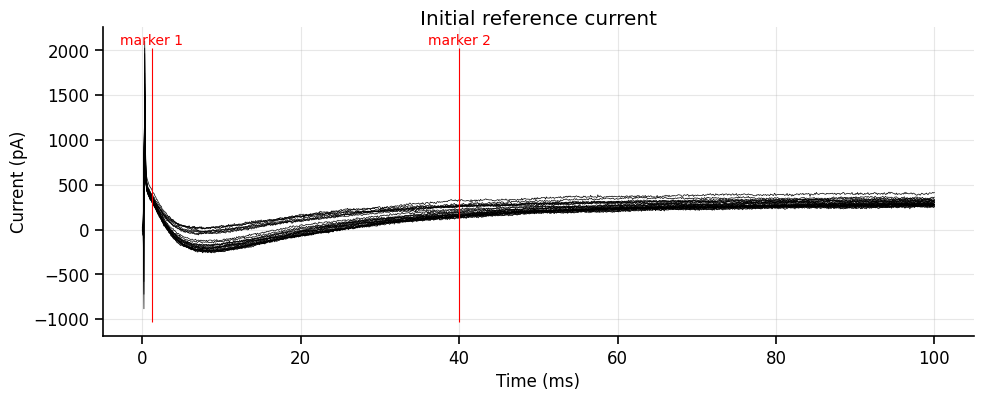

In [8]:
window_size = 100 # ms
marker_1 = 1.2
marker_2 = 40

reference_step_traces = traces.crop(timepoint=step_times[0][0], window=window_size, time_units=time_units)
ax = reference_step_traces.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
ax.set_title('Initial reference current',y=0.98)
plt.show()

reference_currents, _ = traces.get_measurements(start_time=marker_1, end_time=marker_2, measurement_type='min', time_units=time_units)

#### 3.2. Recovery currents

We can now repeat this for the other (recovery) currents

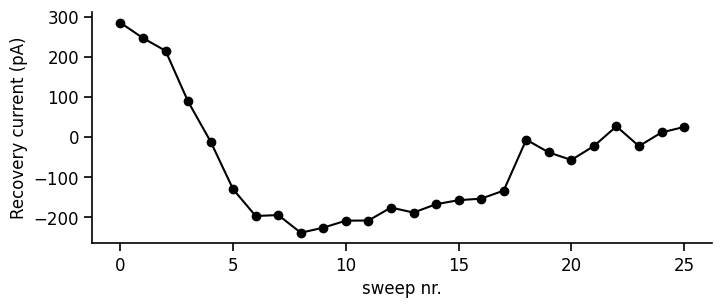

In [9]:
recovery_currents = []
for i, step_time in enumerate(step_times):
    current,_ = traces.get_measurements(sweep=i, measurement_type='min', time_units=time_units, start_time=step_time[1]+marker_1, end_time=step_time[1]+marker_2)
    recovery_currents.append(current)

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = range(len(recovery_currents))
ax.plot(x, recovery_currents, '-o', color='black')
ax.set_ylabel('Recovery current (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

In [10]:
# Normalize the measured currents against the baseline/reference currents
peak_currents_norm = (recovery_currents - np.max(recovery_currents)) / (np.min(recovery_currents) - np.max(recovery_currents))

### 3.4. Plot the channel recovery curve

Here we will need to manually define the recovery time points based on our protocol.

Tau: 11.55 ms


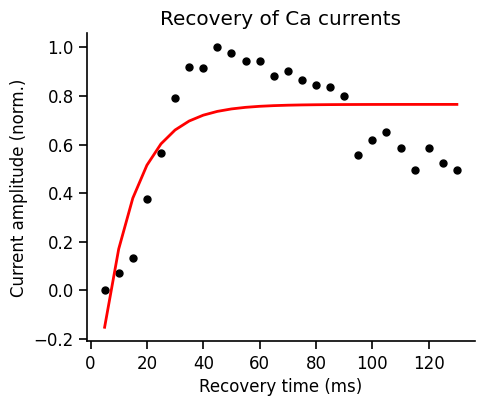

In [11]:
# Define the delta t delays for the recovery
interval_step = 5    # milliseconds

end = interval_step*(len(peak_currents_norm)+1)
recovery_time = np.arange(interval_step, end, interval_step)  # in milliseconds

# Plot the normalized current steps against the holding voltages
%matplotlib inline
fig,ax = plt.subplots(figsize=(5, 4))
ax.plot(recovery_time, peak_currents_norm, 'o', color='black', markersize=5)
ax.set_xlabel('Recovery time (ms)')
ax.set_ylabel('Current amplitude (norm.)')
ax.set_title('Recovery of Ca currents')

# Fit exponential curve to the data to get the time constant
from scipy.optimize import curve_fit
def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf
V0_guess = 0 
Vinf_guess = 1
tau_guess = 20 # ms
p0 = [V0_guess, tau_guess, Vinf_guess]
popt, _ = curve_fit(exponential_curve, recovery_time, peak_currents_norm, p0=p0)
V0_fit, tau_fit, Vinf_fit = popt

print(f"Tau: {tau_fit:.2f} ms")

# Overlay exponential fit
fit_trace = exponential_curve(recovery_time, *popt)
ax.plot(recovery_time, fit_trace, color='r', alpha=1, linewidth=2)
plt.show()